### IMPORTING LIBRARIES & LOADING DATA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### EXPLORATORY DATA ANALYSIS

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### DATA ENGINEERING

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
df_uk = df[df['Country']=='United Kingdom']

In [8]:
df_uk.shape

(495478, 8)

In [9]:
df_uk_user = pd.DataFrame(df_uk['CustomerID'].unique())

In [10]:
df_uk_user.columns = ['CustomerID']

In [11]:
df_uk_user

,CustomerID
0,17850.0
1,13047.0
2,13748.0
3,15100.0
4,15291.0
...,...
3946,15471.0
3947,13436.0
3948,15520.0
3949,13298.0


### I RECENCY

In [12]:
temp = df_uk[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).max().reset_index()

In [13]:
temp['recency'] = (temp['InvoiceDate'].max()-temp['InvoiceDate']).dt.days

In [14]:
temp

,CustomerID,InvoiceDate,recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2
...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277
3946,18281.0,2011-06-12 10:53:00,180
3947,18282.0,2011-12-02 11:43:00,7
3948,18283.0,2011-12-06 12:02:00,3


In [15]:
df_uk_user = df_uk_user.merge(temp, on='CustomerID')

In [16]:
df_uk_user.drop(['InvoiceDate'], axis=1, inplace=True)

### II FREQUENCY

In [17]:
temp = df_uk[['CustomerID', 'InvoiceDate']].groupby(['CustomerID']).count().reset_index()

In [18]:
temp.columns = ['CustomerID', 'frequency']

In [19]:
df_uk_user = df_uk_user.merge(temp, on='CustomerID')

In [20]:
df_uk_user

,CustomerID,recency,frequency
0,17850.0,301,312
1,13047.0,31,196
2,13748.0,95,28
3,15100.0,329,6
4,15291.0,25,109
...,...,...,...
3945,15471.0,1,77
3946,13436.0,1,12
3947,15520.0,1,18
3948,13298.0,0,2


### III MONETARY

In [21]:
temp = df_uk

In [22]:
temp['net_order'] = temp['Quantity']*temp['UnitPrice']

C:\Users\15516\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
temp = temp[['CustomerID', 'net_order']].groupby(['CustomerID']).sum().reset_index()

In [24]:
temp

,CustomerID,net_order
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34
...,...,...
3945,18280.0,180.60
3946,18281.0,80.82
3947,18282.0,176.60
3948,18283.0,2094.88


In [25]:
df_uk_user = df_uk_user.merge(temp, on='CustomerID')

In [26]:
df_uk_user.columns = ['CustomerID', 'recency', 'frequency', 'monetary']

In [27]:
df_uk_user

,CustomerID,recency,frequency,monetary
0,17850.0,301,312,5288.63
1,13047.0,31,196,3079.10
2,13748.0,95,28,948.25
3,15100.0,329,6,635.10
4,15291.0,25,109,4596.51
...,...,...,...,...
3945,15471.0,1,77,469.48
3946,13436.0,1,12,196.89
3947,15520.0,1,18,343.50
3948,13298.0,0,2,360.00


In [28]:
df_uk_user.describe()

,CustomerID,recency,frequency,monetary
count,3950.000000,3950.000000,3950.000000,3950.000000
mean,15562.029367,90.778481,91.614684,1713.385669
std,1576.848325,100.230349,220.557389,6548.608224
min,12346.000000,0.000000,1.000000,-4287.630000
25%,14208.250000,16.000000,17.000000,282.255000
50%,15571.500000,49.000000,41.000000,627.060000
75%,16913.750000,142.000000,101.000000,1521.782500
max,18287.000000,373.000000,7983.000000,256438.490000


### RECENCY CLUSTER

In [29]:
wcss = []
for i in range(1,10):
        model_r = KMeans(n_clusters=i)
        model_r.fit(pd.DataFrame(df_uk_user['recency']))
        wcss.append(model_r.inertia_)

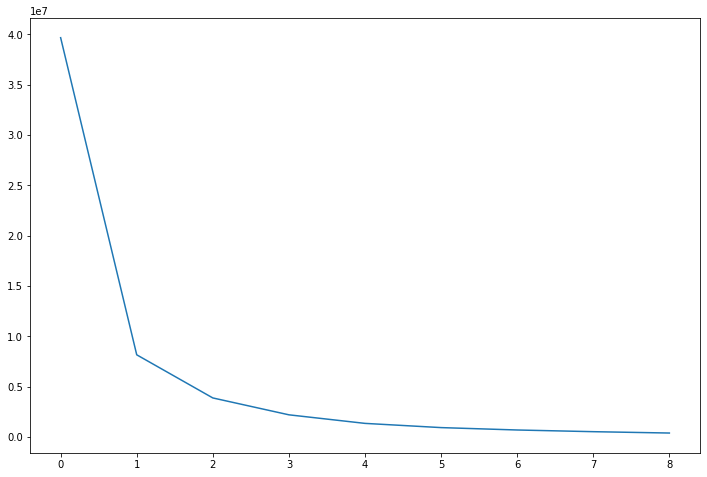

In [30]:
plt.figure(figsize=(12,8))
plt.plot(wcss)

### FREQUENCY CLUSTER

In [31]:
wcss = []
for i in range(1,10):
        model_f = KMeans(n_clusters=i)
        model_f.fit(pd.DataFrame(df_uk_user['frequency']))
        wcss.append(model_f.inertia_)

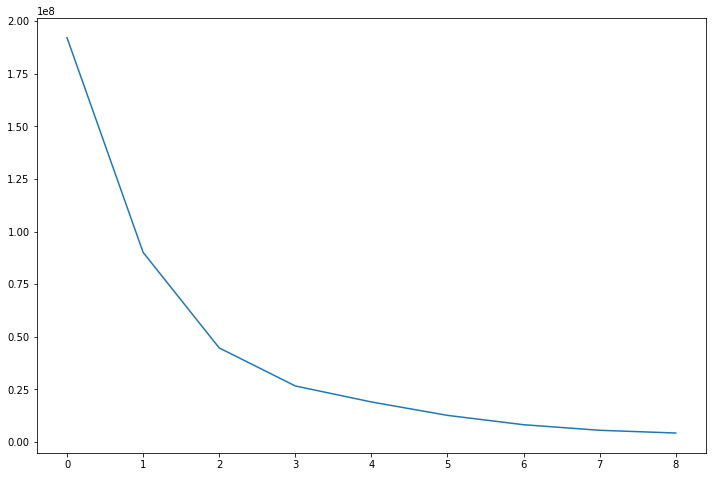

In [32]:
plt.figure(figsize=(12,8))
plt.plot(wcss)

### MONETARY CLUSTER

In [33]:
wcss = []
for i in range(1,10):
        model_m = KMeans(n_clusters=i)
        model_m.fit(pd.DataFrame(df_uk_user['monetary']))
        wcss.append(model_m.inertia_)

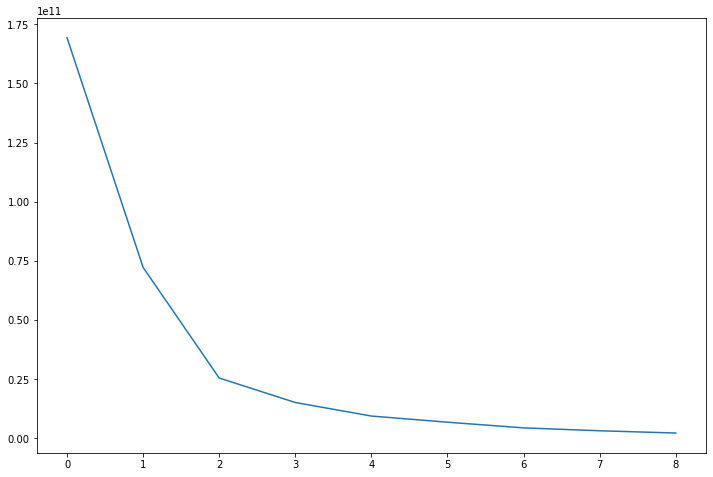

In [34]:
plt.figure(figsize=(12,8))
plt.plot(wcss)

#### 4 Clusters seems to be an ideal number of cluster based on all WCSS

In [35]:
model_r = KMeans(n_clusters=4, random_state=0)
model_r.fit(pd.DataFrame(df_uk_user['recency']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [36]:
df_uk_user['recency_cluster'] = model_r.predict(pd.DataFrame(df_uk_user['recency']))

In [37]:
model_f = KMeans(n_clusters=4, random_state=0)
model_f.fit(pd.DataFrame(df_uk_user['frequency']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [38]:
df_uk_user['frequency_cluster'] = model_f.predict(pd.DataFrame(df_uk_user['frequency']))

In [39]:
model_m = KMeans(n_clusters=4, random_state=0)
model_m.fit(pd.DataFrame(df_uk_user['monetary']))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [40]:
df_uk_user['monetary_cluster'] = model_m.predict(pd.DataFrame(df_uk_user['monetary']))

### SORTING THE CLUSTER

In [41]:
df_uk_user

,CustomerID,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster
0,17850.0,301,312,5288.63,2,2,3
1,13047.0,31,196,3079.10,1,2,0
2,13748.0,95,28,948.25,3,0,0
3,15100.0,329,6,635.10,2,0,0
4,15291.0,25,109,4596.51,1,0,3
...,...,...,...,...,...,...,...
3945,15471.0,1,77,469.48,1,0,0
3946,13436.0,1,12,196.89,1,0,0
3947,15520.0,1,18,343.50,1,0,0
3948,13298.0,0,2,360.00,1,0,0


In [42]:
df_uk_user.groupby(['recency_cluster']).mean()

,CustomerID,recency,frequency,monetary,frequency_cluster,monetary_cluster
recency_cluster,,,,,,
0,15644.091549,184.625000,34.896127,545.543347,0.021127,0.015845
1,15571.513333,17.488205,143.666667,2764.957257,0.427179,0.359487
2,15568.018828,304.393305,23.374477,345.192448,0.008368,0.018828
3,15490.784067,77.679245,53.180294,944.796784,0.073375,0.040881


In [43]:
clust_r = {0:1, 1:3, 2:0, 3:2}

In [44]:
df_uk_user['recency_cluster'] = df_uk_user['recency_cluster'].map(clust_r)

In [45]:
df_uk_user.groupby(['recency_cluster']).mean()

,CustomerID,recency,frequency,monetary,frequency_cluster,monetary_cluster
recency_cluster,,,,,,
0,15568.018828,304.393305,23.374477,345.192448,0.008368,0.018828
1,15644.091549,184.625000,34.896127,545.543347,0.021127,0.015845
2,15490.784067,77.679245,53.180294,944.796784,0.073375,0.040881
3,15571.513333,17.488205,143.666667,2764.957257,0.427179,0.359487


In [46]:
df_uk_user.groupby(['frequency_cluster']).mean()

,CustomerID,recency,frequency,monetary,recency_cluster,monetary_cluster
frequency_cluster,,,,,,
0,15551.502857,99.888000,49.687429,1005.862198,2.008286,0.068286
1,14895.000000,1.333333,5917.666667,42177.930000,3.000000,2.000000
2,15671.503529,20.781176,332.541176,6374.881435,2.875294,1.077647
3,15212.818182,5.954545,1313.136364,18704.422727,3.000000,2.500000


In [47]:
clust_f = {0:0, 1:3, 2:1, 3:2}

In [48]:
df_uk_user['frequency_cluster'] = df_uk_user['frequency_cluster'].map(clust_f)

In [49]:
df_uk_user.groupby(['frequency_cluster']).mean()

,CustomerID,recency,frequency,monetary,recency_cluster,monetary_cluster
frequency_cluster,,,,,,
0,15551.502857,99.888000,49.687429,1005.862198,2.008286,0.068286
1,15671.503529,20.781176,332.541176,6374.881435,2.875294,1.077647
2,15212.818182,5.954545,1313.136364,18704.422727,3.000000,2.500000
3,14895.000000,1.333333,5917.666667,42177.930000,3.000000,2.000000


In [50]:
df_uk_user.groupby(['monetary_cluster']).mean()

,CustomerID,recency,frequency,monetary,recency_cluster,frequency_cluster
monetary_cluster,,,,,,
0,15569.806075,95.937347,67.382967,907.254414,2.051804,0.073501
1,17776.000000,3.500000,392.000000,221960.330000,3.000000,1.000000
2,15140.481481,5.777778,1165.703704,43070.445185,3.000000,1.148148
3,15469.213675,20.047009,346.918803,7760.699530,2.880342,0.743590


In [51]:
clust_m = {0:0, 1:3, 2:2, 3:1}

In [52]:
df_uk_user['monetary_cluster'] = df_uk_user['monetary_cluster'].map(clust_m)

In [53]:
df_uk_user.groupby(['monetary_cluster']).mean()

,CustomerID,recency,frequency,monetary,recency_cluster,frequency_cluster
monetary_cluster,,,,,,
0,15569.806075,95.937347,67.382967,907.254414,2.051804,0.073501
1,15469.213675,20.047009,346.918803,7760.699530,2.880342,0.743590
2,15140.481481,5.777778,1165.703704,43070.445185,3.000000,1.148148
3,17776.000000,3.500000,392.000000,221960.330000,3.000000,1.000000


In [54]:
df_uk_user['overall_score'] = df_uk_user['recency_cluster']+df_uk_user['frequency_cluster']+df_uk_user['monetary_cluster']

In [55]:
df_uk_user.head()

,CustomerID,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,overall_score
0,17850.0,301,312,5288.63,0,1,1,2
1,13047.0,31,196,3079.10,3,1,0,4
2,13748.0,95,28,948.25,2,0,0,2
3,15100.0,329,6,635.10,0,0,0,0
4,15291.0,25,109,4596.51,3,0,1,4


In [56]:
df_uk_user.groupby(['overall_score']).sum()

,CustomerID,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster
overall_score,,,,,,,
0,7379730.0,144373,10426,143783.020,0,0,0
1,8787517.0,104174,18319,279925.201,559,1,2
2,14239757.0,72672,43206,798636.352,1829,7,4
3,23605396.0,31330,104146,1657727.171,4505,31,9
4,4588094.0,4370,80219,1066317.970,878,233,65
5,2307480.0,1430,55247,1352268.010,444,143,153
6,408515.0,209,23653,615003.700,81,42,39
7,108842.0,13,8909,727678.180,21,12,16
8,44685.0,4,17753,126533.790,9,9,6


In [57]:
df_uk_user.groupby(['overall_score']).mean()

,CustomerID,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster
overall_score,,,,,,,
0,15569.050633,304.584388,21.995781,303.339705,0.000000,0.000000,0.000000
1,15636.151246,185.362989,32.596085,498.087546,0.994662,0.001779,0.003559
2,15477.996739,78.991304,46.963043,868.082991,1.988043,0.007609,0.004348
3,15581.119472,20.679868,68.743234,1094.209354,2.973597,0.020462,0.005941
4,15605.761905,14.863946,272.853741,3626.931871,2.986395,0.792517,0.221088
5,15591.081081,9.662162,373.290541,9136.946014,3.000000,0.966216,1.033784
6,15130.185185,7.740741,876.037037,22777.914815,3.000000,1.555556,1.444444
7,15548.857143,1.857143,1272.714286,103954.025714,3.000000,1.714286,2.285714
8,14895.000000,1.333333,5917.666667,42177.930000,3.000000,3.000000,2.000000


### We can clearly notice that customer that fall under 7 & 8 score are high in monetary value, recency & frequency

### SEGMENTATION

In [58]:
df_uk_user['segment'] = 'low-value'
df_uk_user.loc[df_uk_user['overall_score']>4,'segment'] = 'mid-value'
df_uk_user.loc[df_uk_user['overall_score']>6,'segment'] = 'high-value'

In [59]:
temp = df_uk_user.groupby(['segment']).mean()

In [60]:
temp

,CustomerID,recency,frequency,monetary,recency_cluster,frequency_cluster,monetary_cluster,overall_score
segment,,,,,,,,
high-value,15352.700000,1.700000,2666.200000,85421.197000,3.000000,2.100000,2.200000,7.300000
low-value,15564.540239,94.799203,68.078619,1048.177879,2.064011,0.072244,0.021248,2.157503
mid-value,15519.971429,9.365714,450.857143,11241.552629,3.000000,1.057143,1.097143,5.154286


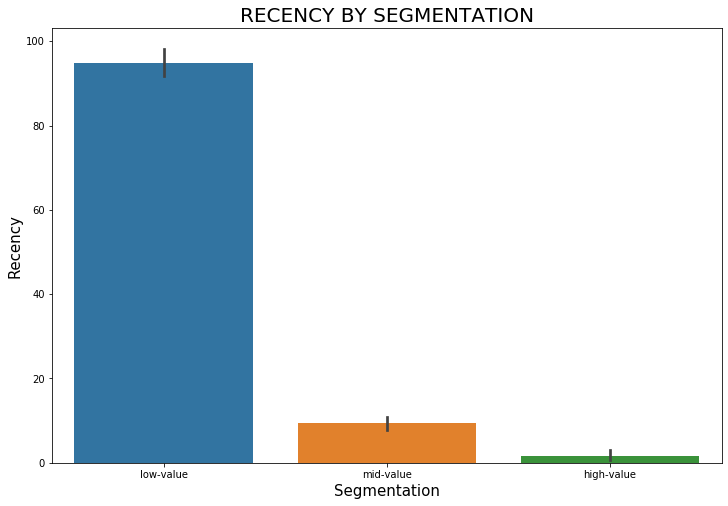

In [61]:
plt.figure(figsize=(12,8))
sns.barplot(df_uk_user['segment'], df_uk_user['recency'])
plt.title('RECENCY BY SEGMENTATION', fontdict={'fontsize':20})
plt.xlabel('Segmentation', fontdict={'fontsize':15})
plt.ylabel('Recency', fontdict={'fontsize':15})
plt.show()

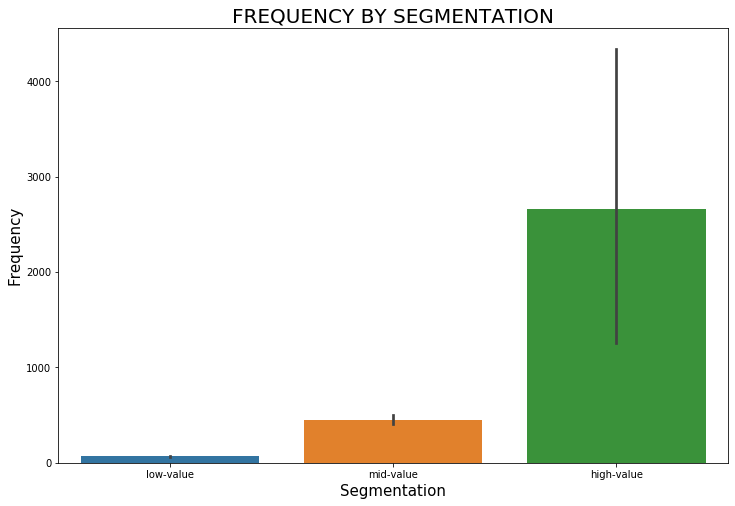

In [62]:
plt.figure(figsize=(12,8))
sns.barplot(df_uk_user['segment'], df_uk_user['frequency'])
plt.title('FREQUENCY BY SEGMENTATION', fontdict={'fontsize':20})
plt.xlabel('Segmentation', fontdict={'fontsize':15})
plt.ylabel('Frequency', fontdict={'fontsize':15})
plt.show()

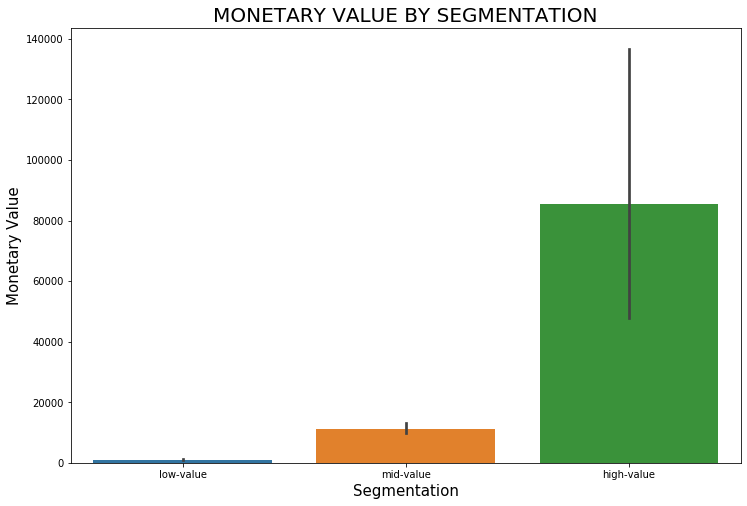

In [63]:
plt.figure(figsize=(12,8))
sns.barplot(df_uk_user['segment'], df_uk_user['monetary'])
plt.title('MONETARY VALUE BY SEGMENTATION', fontdict={'fontsize':20})
plt.xlabel('Segmentation', fontdict={'fontsize':15})
plt.ylabel('Monetary Value', fontdict={'fontsize':15})
plt.show()